# CNN_Softmax - CS 598 DLH - Reproducable Paper Final Project

This contains the code required for the paper titled "A Novel Deep Similarity Learning Approach to Electronic Health Records Data"

Please note some of the code portions might have been used from MY OWN code of CS598-DLH lab/mps

## Environment setup + Data pre-processing

In [1]:
#Environment setup
!pip3 install gdown
!mkdir data
!nvidia-smi
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Imports
import torch
import torch.nn.functional as F
import gdown
import pandas as pd
from tabulate import tabulate
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import math

mkdir: cannot create directory ‘data’: File exists
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
#https://drive.google.com/uc?id=1uBv9j602LGyN43wvbQDpvka49rR9eNUQ&export=download&confirm=t
'''from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1uBv9j602LGyN43wvbQDpvka49rR9eNUQ',
                                    dest_path='./data/orbda.csv',
                                    unzip=True,
                                    showsize=True,
                                    overwrite=True)'''


url = "https://drive.google.com/uc?id=1uBv9j602LGyN43wvbQDpvka49rR9eNUQ"
output = "./data/orbda.csv"
gdown.download(url, output, quiet=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('data/orbda.csv', low_memory=False) #read in csv file (~800mb)

Downloading...
From: https://drive.google.com/uc?id=1uBv9j602LGyN43wvbQDpvka49rR9eNUQ
To: /content/data/orbda.csv
100%|██████████| 818M/818M [00:06<00:00, 130MB/s]


In [3]:
#Sanity checks for pandas import + read_csv
#print(df.columns)
#print(sorted(df['ap_cidpri'].unique()))
#df.head()
#print(df['id_'].nunique())
#print(df['id_'].count())
#print(df['ap_coduni'].unique())
#print(df['ap_coduni'].count())

In [4]:
#Filtering out for specific values as outlined in Table 3
kidney_codes = ['E10 ', 'E14 ', 'I10 ', 'I120', 'N039', 'N088', 'N083', 'N180', 'N188', 'N189']
df = df.loc[df['ap_cidpri'].isin(kidney_codes)]

In [5]:
#Filtering out columns to match input features
#Features: an_hcv, an_hiv, an_hbsag, ap_nuidade, ap_coduni, owner_id, ap_pripal, ap_motsai, estado, an_tru, an_intfis, vol
column_features = ['an_hcv', 'an_hiv', 'an_hbsag', 'ap_nuidade', 'ap_coduni', 'ap_pripal', 'ap_motsai', 'estado', 'an_tru', 'an_intfis', 'ap_cidpri']
df_input_features = df.filter(items=column_features)
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))

+----+----------+----------+------------+--------------+------------------+-------------+-------------+----------+----------+-------------+-------------+
|    | an_hcv   | an_hiv   | an_hbsag   |   ap_nuidade | ap_coduni        |   ap_pripal |   ap_motsai | estado   |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+------------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 | N        | N        | N          |           25 | a1042cb8e9265d4e |   305010107 |          21 | MG       |     628  |          03 | N180        |
|  1 | N        | N        | N          |           47 | 69ba059ff91532d3 |   305010107 |          21 | RJ       |     0065 |          00 | N180        |
|  2 | N        | N        | N          |           15 | a2b516fa1aa3cce0 |   305010107 |          21 | PR       |     0    |          01 | N180        |
|  3 | N        | N        | N          |           37 | 72f15d07e504318f | 

In [6]:
#Converting ap_coduni values into int via dict
coduni_dict = {}
unique_coduni = df_input_features['ap_coduni'].unique()
for i in range(0, len(unique_coduni)):
  coduni_dict[unique_coduni[i]] = i
df_input_features = df_input_features.replace({'ap_coduni': coduni_dict})
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))

+----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------+
|    | an_hcv   | an_hiv   | an_hbsag   |   ap_nuidade |   ap_coduni |   ap_pripal |   ap_motsai | estado   |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 | N        | N        | N          |           25 |           0 |   305010107 |          21 | MG       |     628  |          03 | N180        |
|  1 | N        | N        | N          |           47 |           1 |   305010107 |          21 | RJ       |     0065 |          00 | N180        |
|  2 | N        | N        | N          |           15 |           2 |   305010107 |          21 | PR       |     0    |          01 | N180        |
|  3 | N        | N        | N          |           37 |           3 |   305010107 |          21 | RJ     

In [7]:
#Converting an_hcv, an_hiv, an_hbsag to int values from dict
yes_no_dict = {'N': 0, "P": 1}
df_input_features = df_input_features.replace({'an_hcv': yes_no_dict, 'an_hiv': yes_no_dict, 'an_hbsag': yes_no_dict})
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))

+----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------+
|    |   an_hcv |   an_hiv |   an_hbsag |   ap_nuidade |   ap_coduni |   ap_pripal |   ap_motsai | estado   |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 |        0 |        0 |          0 |           25 |           0 |   305010107 |          21 | MG       |     628  |          03 | N180        |
|  1 |        0 |        0 |          0 |           47 |           1 |   305010107 |          21 | RJ       |     0065 |          00 | N180        |
|  2 |        0 |        0 |          0 |           15 |           2 |   305010107 |          21 | PR       |     0    |          01 | N180        |
|  3 |        0 |        0 |          0 |           37 |           3 |   305010107 |          21 | RJ     

In [8]:
#Converting estado to int values from dict
estado_dict = {}
unique_estado = df_input_features['estado'].unique()
for i in range(0, len(unique_estado)):
  estado_dict[unique_estado[i]] = i
df_input_features = df_input_features.replace({'estado': estado_dict})
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))

+----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------+
|    |   an_hcv |   an_hiv |   an_hbsag |   ap_nuidade |   ap_coduni |   ap_pripal |   ap_motsai |   estado |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 |        0 |        0 |          0 |           25 |           0 |   305010107 |          21 |        0 |     628  |          03 | N180        |
|  1 |        0 |        0 |          0 |           47 |           1 |   305010107 |          21 |        1 |     0065 |          00 | N180        |
|  2 |        0 |        0 |          0 |           15 |           2 |   305010107 |          21 |        2 |     0    |          01 | N180        |
|  3 |        0 |        0 |          0 |           37 |           3 |   305010107 |          21 |        

In [9]:
#Converting an_tru to int values from dict 
df_input_features['an_tru'] = df_input_features['an_tru'].str.strip()
df_input_features['an_tru'] = df_input_features['an_tru'].str.extract('(\d+)', expand=False)


In [10]:
#Converting an_intfis to int values from dict 

intfis_dict = {}
unique_intfis = df_input_features['an_intfis'].unique()
for i in range(0, len(unique_intfis)):
  intfis_dict[unique_intfis[i]] = i
df_input_features = df_input_features.replace({'an_intfis': intfis_dict})
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))

+----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------+
|    |   an_hcv |   an_hiv |   an_hbsag |   ap_nuidade |   ap_coduni |   ap_pripal |   ap_motsai |   estado |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 |        0 |        0 |          0 |           25 |           0 |   305010107 |          21 |        0 |      628 |           0 | N180        |
|  1 |        0 |        0 |          0 |           47 |           1 |   305010107 |          21 |        1 |     0065 |           1 | N180        |
|  2 |        0 |        0 |          0 |           15 |           2 |   305010107 |          21 |        2 |        0 |           2 | N180        |
|  3 |        0 |        0 |          0 |           37 |           3 |   305010107 |          21 |        

In [11]:
#Converting pandas object types into integer
df_input_features = df_input_features.dropna()
df_input_features['an_hcv'] = df_input_features['an_hcv'].astype('str').astype('float')
df_input_features['an_hiv'] = df_input_features['an_hiv'].astype('str').astype('float')
df_input_features['an_hbsag'] = df_input_features['an_hbsag'].astype('str').astype('float')
df_input_features['an_tru'] = df_input_features['an_tru'].astype('str').astype('float')
df_input_features['an_intfis'] = df_input_features['an_intfis'].astype('str').astype('float')

In [12]:
#Sanity checks post filtering
#display(df.groupby('ap_cidpri')['ap_cidpri'].transform('count'))
print(tabulate(df['ap_cidpri'].value_counts().to_frame(), headers = 'keys', tablefmt = 'psql'))
print(tabulate(df_input_features.head(), headers = 'keys', tablefmt = 'psql'))
print(df_input_features.dtypes)

+------+-----------------+
|      |       ap_cidpri |
|------+-----------------|
| N180 |     3.94376e+06 |
| N189 | 38160           |
| I120 | 19460           |
| N039 |  7349           |
| I10  |  5979           |
| N083 |  5782           |
| N188 |  4670           |
| N088 |  1698           |
| E10  |   190           |
| E14  |   168           |
+------+-----------------+
+----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------+
|    |   an_hcv |   an_hiv |   an_hbsag |   ap_nuidade |   ap_coduni |   ap_pripal |   ap_motsai |   estado |   an_tru |   an_intfis | ap_cidpri   |
|----+----------+----------+------------+--------------+-------------+-------------+-------------+----------+----------+-------------+-------------|
|  0 |        0 |        0 |          0 |           25 |           0 |   305010107 |          21 |        0 |      628 |           0 | N180        |
|  1 |        0 |        0

In [13]:
#Converting categorical lables to one hot encoding
kidney_codes_dict = {'E10 ': 1, 'E14 ': 2, 'I10 ': 3, 'I120': 4, 'N039': 4, 'N088': 5, 'N083': 6, 'N180': 7, 'N188': 8, 'N189': 9}

cidpri_list = df_input_features['ap_cidpri'].tolist()
for i in range(0, len(cidpri_list)):
  cidpri_list[i] = kidney_codes_dict[cidpri_list[i]]

tensor_cidpri = torch.tensor(cidpri_list)
cidpri_one_hot = F.one_hot(tensor_cidpri)

#Drop cidpri column since we are now done with it
df_input_features = df_input_features.drop(['ap_cidpri'], axis=1)

In [14]:
#Dataloader calss
import random
class NephrologyDataset(Dataset):
  def __init__(self, input_features, categorical_features):
    x = input_features.values
    y = categorical_features
    #print(y)

    self.x_train = x#torch.tensor(x, device=device)
    self.y_train = cidpri_list#y#y.to(device)#torch.tensor(y, device=device)

  def __len__(self):
    return math.floor(len(self.y_train)/2)
  
  def __getitem__(self, idx):
    if (idx + 2> self.__len__()):
      idx = idx-3
    second_idx = random.randint(0, self.__len__()-1)
    return torch.tensor(self.x_train[idx], device=device), torch.tensor(self.x_train[second_idx], device=device), torch.tensor((self.y_train[second_idx] == self.y_train[idx]), device=device).float()

In [15]:
#Dataloader initialization
split_train = int((len(cidpri_one_hot)) * .8)
split_test = int((len(cidpri_one_hot)) * .2)
dataloader_train = NephrologyDataset(df_input_features[:split_train], cidpri_list[:split_train])
dataloader_test = NephrologyDataset(df_input_features[:-split_test], cidpri_list[:-split_test])
train_loader = DataLoader(dataloader_train,batch_size=10000,shuffle=True, drop_last=True)
test_loader = DataLoader(dataloader_test,batch_size=10000,shuffle=True, drop_last=True)

sample_ex = next(iter(test_loader))
print(len(sample_ex))
x, y, l = sample_ex
print(x[0])
print(y[0])
print(l[0])

3
tensor([1.0000e+00, 0.0000e+00, 1.0000e+00, 5.9000e+01, 6.1900e+02, 3.0501e+08,
        2.1000e+01, 4.0000e+00, 7.7000e+01, 5.0000e+00], dtype=torch.float64)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4000e+01, 1.4700e+02, 3.0501e+08,
        2.1000e+01, 8.0000e+00, 9.6000e+01, 9.0000e+00], dtype=torch.float64)
tensor(1.)


In [66]:
#CNN_Softmax model definition
class CNN_Eucledian(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_a = torch.nn.Conv1d(in_channels=10, 
                                      out_channels=25, 
                                      kernel_size=1, bias=False)
        self.conv_b = torch.nn.Conv1d(in_channels=25, 
                                      out_channels=37, 
                                      kernel_size=1)
        self.maxpool_a = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.maxpool_b = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.fc = torch.nn.Linear(in_features=37, 
                                  out_features=10)
        self.sm_fc = torch.nn.Linear(in_features=10000,
                                     out_features=1)
        self.sm_fc2 = torch.nn.Linear(in_features=10,
                                      out_features=1)
        self.sm = torch.nn.Softmax(dim=1)

    def forward_single(self, x):
        #x = torch.permute(x, (0, 2, 1))
        x = self.conv_a(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_a(x)

        #print('Finished first conv')
        x = self.conv_b(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_b(x).squeeze()
        x = self.fc(x)

        return x

    def forward(self, x, y):
        #for name, param in self.named_parameters():
        x = x.unsqueeze(dim=2).float()
        y = y.unsqueeze(dim=2).float()
        patient1 = self.forward_single(x)
        patient2 = self.forward_single(y)

        dist = torch.cdist(patient1, patient2)
        dist = self.sm(dist)
        dist = self.sm_fc(dist)
        print(dist.shape)
        return 1-torch.abs(dist)


In [67]:
#Test/Validate model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import accuracy_score

def validate(loader, model, criterion):                       
    correct = 0                                               
    total = 0                                                 
    running_loss = []
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate((loader)):
            x, y, label = data      
                                                              
            outputs = net(x, y)
            outputs = outputs > 0.5
            outputs = outputs.float()
            loss = criterion(outputs, label.unsqueeze(dim=1)) 
            #print(outputs.shape)
            outputs = torch.round(outputs)
            total += label.shape[0]
            correct += np.sum(outputs.squeeze().tolist() == label.squeeze().tolist())
            running_loss.append(loss.item())
            print(correct)      
    mean_val_accuracy = (100 * correct / total)               
    mean_val_loss = np.mean(running_loss)                  
    mean_val_accuracy = accuracy(outputs,labels)       
    print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
    print('Validation Loss:'  ,mean_val_loss )  

def eval(model, val_loader):
    
    """
    Evaluate the model.
    
    Arguments:
        model: the RNN model
        val_loader: validation dataloader
        
    Outputs:
        precision: overall precision score
        recall: overall recall score
        f1: overall f1 score
        roc_auc: overall roc_auc score
        
    REFERENCE: checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    """
    
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    model.eval()
    for i, data in enumerate(tqdm(val_loader)):
        x, y, label = data      
        outputs = net(x, y)

        #https://discuss.pytorch.org/t/confused-about-binary-classification-with-pytorch/83759/10
        y_hat = (outputs >= 0.8).float()
        #print(y_hat[:10])
        
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, label.detach().to('cpu')), dim=0)
    
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    return p, r, f, acc

p, r, f, acc = eval(net, test_loader)
print(p)
print(r)
print(f)
print(acc)

  1%|          | 1/159 [00:00<01:21,  1.95it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  1%|▏         | 2/159 [00:01<01:21,  1.94it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  2%|▏         | 3/159 [00:01<01:18,  1.98it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  3%|▎         | 4/159 [00:01<01:08,  2.25it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  3%|▎         | 5/159 [00:02<01:11,  2.15it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  4%|▍         | 6/159 [00:02<01:05,  2.35it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  4%|▍         | 7/159 [00:03<01:07,  2.25it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  5%|▌         | 8/159 [00:03<01:01,  2.45it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  6%|▌         | 9/159 [00:04<01:07,  2.22it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  6%|▋         | 10/159 [00:04<01:01,  2.42it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  7%|▋         | 11/159 [00:04<01:04,  2.30it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  8%|▊         | 12/159 [00:05<00:59,  2.47it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  8%|▊         | 13/159 [00:05<01:02,  2.33it/s]

tensor([1.], grad_fn=<SelectBackward0>)


  8%|▊         | 13/159 [00:05<01:07,  2.17it/s]


KeyboardInterrupt: ignored

In [68]:
#CNN_Softmax model definition
class CNN_Softmax_old(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_a = torch.nn.Conv1d(in_channels=10, 
                                      out_channels=25, 
                                      kernel_size=1, bias=False)
        self.conv_b = torch.nn.Conv1d(in_channels=25, 
                                      out_channels=37, 
                                      kernel_size=1)
        self.maxpool_a = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.maxpool_b = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.fc = torch.nn.Linear(in_features=37, 
                                  out_features=10)
        self.sm_fc = torch.nn.Linear(in_features=10010,
                                     out_features=1)
        self.sm_fc2 = torch.nn.Linear(in_features=10,
                                      out_features=1)
        self.sm = torch.nn.Softmax(dim=1)

    def forward_single(self, x):
        #x = torch.permute(x, (0, 2, 1))
        x = self.conv_a(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_a(x)

        #print('Finished first conv')
        x = self.conv_b(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_b(x).squeeze()
        x = self.fc(x)
        #x = F.relu(x)
        #x = self.sm(x)
        #print(x.shape)
        #x = self.sm_fc2(x)
        #print(x.shape)
        return x

    def forward(self, x, y):
        #for name, param in self.named_parameters():
          #print(name, param.shape)
        x = x.unsqueeze(dim=2).float()
        y = y.unsqueeze(dim=2).float()
        patient1 = self.forward_single(x)
        patient2 = self.forward_single(y)

        matching_matrix = torch.matmul(self.fc.weight, self.fc.weight.T)

        S = torch.matmul(patient1, patient2.T)
        K = torch.add(patient1, patient2)

        #print("S: " + str(S.shape))
        #print("K: " + str(K.shape))
        ks_cat = torch.cat((S, K), dim=1)
        #print("kscat: " + str(ks_cat.shape))
        #print(score.shape)
        score=ks_cat
        score = self.sm(score)
        #score = F.relu(x).squeeze()
        #print(score.shape)
        score = self.sm_fc(score)
        #score = torch.round(score)
        #score = (torch.max(K, dim=1)[0]).float()
        #score = score.clone().detach().requires_grad_(True)
        #print("score: " + str(score.shape))
        #print(score[:11])
        return 1-torch.abs(score)


In [69]:
#CNN_Softmax model definition
class CNN_Cosine(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_a = torch.nn.Conv1d(in_channels=10, 
                                      out_channels=25, 
                                      kernel_size=1, bias=False)
        self.conv_b = torch.nn.Conv1d(in_channels=25, 
                                      out_channels=37, 
                                      kernel_size=1)
        self.maxpool_a = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.maxpool_b = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.fc = torch.nn.Linear(in_features=37, 
                                  out_features=10)
        self.sm_fc = torch.nn.Linear(in_features=10000,
                                     out_features=1)
        self.sm_fc2 = torch.nn.Linear(in_features=10,
                                      out_features=1)
        self.cos = torch.nn.CosineSimilarity(dim=1)
        self.sm = torch.nn.Softmax(dim=1)

    def forward_single(self, x):
        #x = torch.permute(x, (0, 2, 1))
        x = self.conv_a(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_a(x)

        #print('Finished first conv')
        x = self.conv_b(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_b(x).squeeze()
        x = self.fc(x)

        return x

    def forward(self, x, y):
        #for name, param in self.named_parameters():
        x = x.unsqueeze(dim=2).float()
        y = y.unsqueeze(dim=2).float()
        patient1 = self.forward_single(x)
        patient2 = self.forward_single(y)

        dist = self.cos(patient1, patient2).unsqueeze(dim=1)
        dist = self.sm(dist)
        print(dist[0])
        return torch.abs(dist)

In [71]:
#CNN_Softmax model definition
class CNN_Softmax_custom(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_a = torch.nn.Conv1d(in_channels=10, 
                                      out_channels=25, 
                                      kernel_size=1, bias=False)
        self.conv_b = torch.nn.Conv1d(in_channels=25, 
                                      out_channels=37, 
                                      kernel_size=1)
        self.conv_c = torch.nn.Conv1d(in_channels=37, 
                                      out_channels=60, 
                                      kernel_size=1)
        self.maxpool_a = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.maxpool_b = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.maxpool_c = torch.nn.MaxPool1d(kernel_size=1,
                                            stride=1)
        self.fc = torch.nn.Linear(in_features=60, 
                                  out_features=10)
        self.sm_fc = torch.nn.Linear(in_features=10010,
                                     out_features=1)
        self.sm_fc2 = torch.nn.Linear(in_features=10,
                                      out_features=1)
        self.sm = torch.nn.Softmax(dim=1)

    def forward_single(self, x):
        #x = torch.permute(x, (0, 2, 1))
        x = self.conv_a(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_a(x)

        #print('Finished first conv')
        x = self.conv_b(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_b(x)

        x = self.conv_c(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool_c(x).squeeze()

        x = self.fc(x)
        return x

    def forward(self, x, y):
        x = x.unsqueeze(dim=2).float()
        y = y.unsqueeze(dim=2).float()
        patient1 = self.forward_single(x)
        patient2 = self.forward_single(y)

        matching_matrix = torch.matmul(self.fc.weight, self.fc.weight.T)

        S = torch.matmul(patient1, patient2.T)
        K = torch.add(patient1, patient2)

        ks_cat = torch.cat((S, K), dim=1)
        score=ks_cat
        score = self.sm(score)
        score = self.sm_fc(score)

        return 1-torch.abs(score)


In [72]:
#Train
import torch.optim as optim

print(device)
#net = CNN_Softmax_old().to(device)
#net = CNN_Eucledian().to(device)
#net = CNN_Cosine().to(device)
net = CNN_Softmax_custom().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)


loss_values = []
vanishing = False
for epoch in (range(1)):  # loop over the dataset multiple times
    running_loss = []
    for i, data in enumerate(train_loader):
        # get the inputs
        x, y, label = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print("loader shape: " + str(label.shape))
        #print(label[:10])
        outputs = net(x, y)

        label = label.unsqueeze(dim=1)
        #outputs = outputs.unsqueeze(dim=1).squeeze(dim=2)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        #print(running_loss)
        #if(loss.item() == np.mean(running_loss) and len(running_loss) != 0):
          #print("Vanishing gradient: " + str(loss.item()))
          #vanishing=True
          #break

    loss_values.append(np.mean(running_loss))
    print(np.mean(running_loss))
    p, r, f, acc = eval(net, test_loader)
    print(p)
    print(r)
    print(f)
    print(acc)
    #validate(test_loader, net, criterion)
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "epoch_model.tar")


print('Finished Training')
print(loss_values)

cpu
0.0


100%|██████████| 159/159 [02:18<00:00,  1.15it/s]


0.9633943396226415
1.0
0.9813559305746017
0.9633943396226415
Finished Training
[0.0]


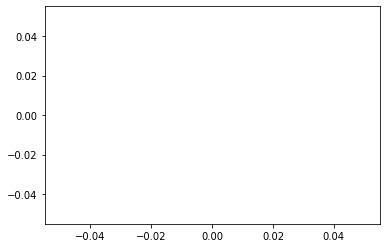

In [62]:
#Graphs + Analysis
plt.plot(np.squeeze(loss_values[1:]))

In [73]:
#Saving model
torch.save(net, "full_model.pt")
torch.save(net.state_dict(), "model_dict.pt")